# Import all packages and define functions used for data-preprocessing 
# Reads the dataset

In [1]:
#### Import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree, neighbors, svm
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve

import warnings
# To ignore any future warnings
warnings.filterwarnings("ignore")

# Repeated functions
def getMode(df, attribute, condAtt, cond):
    return (df[attribute][df[condAtt]==cond].mode()[0])

def replaceWithMode(df, attribute, condAtt, cond):
    mode = getMode(df, attribute, condAtt, cond)
    df[attribute] = df[attribute].mask(((df[condAtt]==cond) & (df[attribute]=='?')), mode)
    

# read the dataset and set skipinitialspace to true to be able to .replace
df = pd.read_csv('./HouseholderAtRisk(1).csv', skipinitialspace=True)



# Task 1 
**1)      What proportion of households who have high risk?**

Properties with high risks are calculated with value_counts

In [2]:
# Task 1 question 1
# Show proportion of high risk
risks = df['AtRisk'].value_counts()
print("Proportion of high risk = " + str(risks[0]/len(df)))

Proportion of high risk = 0.7624690617265432


# Task 1
**2) Did you have to fix any data quality problems? Detail them?**


In [3]:
# Drop rows with multiple columns containing NaN values
df = df.dropna(subset=["Relationship", "Sex", "NumYearsEducation"], how='all')

# Replace inconsistency in CountryOfOrigin
df['CountryOfOrigin'] = df['CountryOfOrigin'].replace("US", "USA").replace("United-States", "USA")

##Replace ? to mode in CountryOfOrigin
modeCountry = df['CountryOfOrigin'].mode()[0]
df.loc[df['CountryOfOrigin']=='?', 'CountryOfOrigin'] = modeCountry

# Removing Gender to use numerical binary for Sex where 0 = Male, 1 = Female
df.drop('Gender', axis=1, inplace=True)

# Replace -1 value in Age with mean value
modeAge = df['Age'].mode()[0]
df.loc[df['Age']==-1, 'Age'] = modeAge

# Round off age
df['Age'] = df['Age'].astype(int)

# Drop race as there are 39954 NaN vs 45 labelled classes
df.drop('Race', axis=1, inplace=True)


# Sets upper boundary of 90 hours work week in NumWorkingHoursPerWeek and fills with mean value
modeWorkHours = df['NumWorkingHoursPerWeek'].mode()[0]
df['NumWorkingHoursPerWeek'] = df['NumWorkingHoursPerWeek'].where(df['NumWorkingHoursPerWeek'] <= 90, modeWorkHours)  
# Round off hours                             
df['NumWorkingHoursPerWeek'] = df['NumWorkingHoursPerWeek'].astype(int)

# Replaces missing data with mean of column
df['Weighting'] = df['Weighting'].fillna(df['Weighting'].mean())


# Replaces missing data with unknown Occupation
df['Occupation'] = df['Occupation'].fillna("?")

# Replaces unknowns with the mode of attribute
# By WorkClass
replaceWithMode(df,'Occupation','WorkClass','Federal-gov')
replaceWithMode(df,'Occupation','WorkClass','Self-emp-inc')
replaceWithMode(df,'Occupation','WorkClass','Private')
replaceWithMode(df,'Occupation','WorkClass','Never-worked')

# By education
for values in df['Education'].unique():
    replaceWithMode(df, 'Occupation', 'Education', values)
    replaceWithMode(df, 'WorkClass', 'Education', values)


# Never-worked adults will have occupation set as other services as a generic unknown
df['Occupation'] = df['Occupation'].mask(((df['WorkClass']=='Never-worked') & (df['Occupation']=='?')), "Other-service")


# Turning CapitalAvg into binary options 
df['CapitalAvg'][df['CapitalAvg'] > 0] = 1
df['CapitalAvg'] = df['CapitalAvg'].astype(int)

In [4]:
# Converting weight from 1 to 4 based on equal intervals (equi-width)
weightMax = df['Weighting'].max()
bins = [0, weightMax/4, weightMax/2, weightMax*3/4,  weightMax+1]
labels =[1,2,3,4]
df['Weighting'] = pd.cut(df['Weighting'], bins,labels=labels)
print (df['Weighting'])

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       2
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       2
26       1
27       1
28       1
29       1
        ..
39969    1
39970    1
39971    1
39972    1
39973    1
39974    1
39975    1
39976    1
39977    1
39978    1
39979    1
39980    1
39981    1
39982    2
39983    1
39984    1
39985    1
39986    1
39987    1
39988    1
39989    1
39990    1
39991    1
39992    1
39993    1
39994    1
39995    1
39996    1
39997    1
39998    1
Name: Weighting, Length: 39027, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]


In [5]:
# Converting age from 1 to 4 based on equal intervals (equi-width)
df['Age'].max()
ageMax = df['Age'].max()
bins = [0, ageMax/4, ageMax/2, ageMax*3/4,  ageMax+1]
labels =[1,2,3,4]
df['Age'] = pd.cut(df['Age'], bins,labels=labels)

In [6]:
# Converting education years from 1 to 4 based on equal intervals (equi-width)
df['NumYearsEducation'].max()
eduMax = df['NumYearsEducation'].max()
bins = [0, eduMax/4, eduMax/2, eduMax*3/4,  eduMax+1]
labels =[1,2,3,4]
df['NumYearsEducation'] = pd.cut(df['NumYearsEducation'], bins,labels=labels)

In [7]:
###Mappings

atriskclassMapping = {'High': 1, 'Low':0} #Binary

workclassMapping = {'Private':0, 'Local-gov': 1, 'Self-emp-not-inc':2, 'Federal-gov': 3, 'State-gov': 4,  'Self-emp-inc': 5\
                    ,'Without-pay':6, 'Never-worked':7}

educationclassMapping = {'Preschool':0,'1st-4th': 1, '5th-6th': 2, '7th-8th': 3, '9th': 4, '10th': 5,
       '11th':6, '12th':7,'HS-grad':8, 'Some-college':9, 'Bachelors':10, 'Prof-school':11, 'Masters': 12, 'Doctorate': 13,
                         'Assoc-acdm': 14, 'Assoc-voc': 15} #Ordinal?? not sure of order

maritalstatusclassMapping = {'Never-married': 0, 'Married-civ-spouse': 1, 'Widowed': 2, 'Divorced':3,
       'Separated':4, 'Married-spouse-absent':5, 'Married-AF-spouse':6 }

occupationclassMapping = {'Machine-op-inspct': 0 , 'Farming-fishing': 1, 'Protective-serv': 2,
       'Adm-clerical': 3, 'Other-service': 4, 'Craft-repair': 5, 'Prof-specialty': 6,
       'Exec-managerial': 7, 'Tech-support': 8, 'Sales': 9, 'Priv-house-serv': 10,
       'Transport-moving': 11, 'Handlers-cleaners': 12, 'Armed-Forces': 13}

relationshipclassMapping = {'Own-child': 0, 'Husband':1, 'Not-in-family':2, 'Unmarried':3, 'Wife':4,
       'Other-relative':5}

countryclassMapping = {'USA':1, 'Peru':1, 'Guatemala':1, 'Mexico':1, 'Dominican-Republic':1,
       'Ireland':2, 'Germany':2, 'Philippines':3, 'Thailand':3, 'Haiti':1,
       'El-Salvador':1, 'Puerto-Rico':1, 'Vietnam':3, 'South':3, 'Columbia':1,
       'Japan':3, 'India':4, 'Cambodia':1, 'Poland':2, 'Laos':3, 'England':2, 'Cuba':1,
       'Taiwan':2, 'Italy':2, 'Canada':1, 'Portugal':2, 'China':3, 'Nicaragua':1,
       'Honduras':1, 'Iran':4, 'Scotland':2, 'Jamaica':1, 'Ecuador':1, 'Yugoslavia':1,
       'Hungary':2, 'Hong':3, 'Greece':2, 'Trinadad&Tobago':1,
       'Outlying-US(Guam-USVI-etc)':1, 'France':2, 'Holand-Netherlands':2}

df['AtRisk'] = df['AtRisk'].map(atriskclassMapping).astype(int)
df['WorkClass'] = df['WorkClass'].map(workclassMapping).astype(int)
df['Education'] = df['Education'].map(educationclassMapping).astype(int)
df['Marital-Status'] = df['Marital-Status'].map(maritalstatusclassMapping).astype(int)
df['Occupation'] = df['Occupation'].map(occupationclassMapping).astype(int)
df['Relationship'] = df['Relationship'].map(relationshipclassMapping).astype(int)
df['CountryOfOrigin'] = df['CountryOfOrigin'].map(countryclassMapping).astype(int)
df['NumYearsEducation']= df['NumYearsEducation'].astype(int)

# Task 2 Predictive Modelling using Decision Trees

**Dataset is split into target and input types**

By dropping ID, target variable and other object types, a decision tree can be formed.

Cross-fold validation with k=10 is done to the training set of 70%, having 7% for each fold. Then, it is fitted and ready for analysis


In [8]:
# target/input split
y = df['AtRisk']
# Drop all object type (temporarily)
X = df.drop(['ID', 'CapitalLoss', 'CapitalGain', 'AtRisk'], axis=1)

X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=10)

# simple decision tree training
clf = DecisionTreeClassifier(random_state=10)
K_fold = cross_val_score(clf, X_train, y_train, cv=10)
clf.fit(X_train, y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=10, splitter='best')

# Task 2 

**1a) What is classification accuracy on training and test datasets?**

**b) Which variable is used for the first split? What are the variables that are used for the second split?**

Before binning age: 0.76~78

After binning age: 0.798

After binning age and weighting: 0.7975

And numyearsedu: 0.79776

In [9]:
# Task 2 1a
print("Train accuracy:", clf.score(X_train, y_train))
print("Test accuracy:", clf.score(X_test, y_test))

# Task 2 1b

# grab feature importances from the model and feature name from the original X
importances = clf.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

for i in indices:
    print(feature_names[i], ':', importances[i])

Train accuracy: 0.9230910022695659
Test accuracy: 0.8007515586301136
Marital-Status : 0.27062482243689434
NumWorkingHoursPerWeek : 0.15970204490200668
NumYearsEducation : 0.1576102469549165
Occupation : 0.09921711455636364
WorkClass : 0.06716255151024704
CapitalAvg : 0.059409490387715334
Education : 0.05845210233198633
Age : 0.042880059452403835
Relationship : 0.030868494459210312
CountryOfOrigin : 0.018824098086715868
Sex : 0.018076910643538842
Weighting : 0.017172064278001335


# Task 2

**2) Build another decision tree tuned with GridSearchCV**

With this, we have set the hyperparameters as the maximum depth of tree, and test against depths of 1 to 100, with cross fold validation of k=5. Then, the accuracy and scores are printed.

Before binning age: 0.8360<br>
After binning age: 0.83659<br>
After binning age and weighting: 0.83673<br>
And numyearsedu: 0.83498

In [10]:
clf = DecisionTreeClassifier(random_state=5)
tree_depth = np.arange(1,100)

gs = GridSearchCV(clf, param_grid={'max_depth':tree_depth}, iid=True, cv=5)

#K_fold_prediction = cross_val_score(gs, X_train, y_train, cv=3)
#print("Accuracy: %0.2f (+/- %0.2f)" % (K_fold_prediction.mean(), K_fold_prediction.std() * 2))
#print("Cross validation scores are:", K_fold_prediction)

gs.fit(X_train, y_train)
print("The training set gave a best score of " + str(gs.best_score_))
    

The training set gave a best score of 0.8350172047734095


In [11]:
print (str(gs.best_params_))
print (str(gs.best_estimator_))

{'max_depth': 9}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=5, splitter='best')


In [12]:
##Variables
#get attribute scores from best model
best_est = gs.best_estimator_
# grab feature importances from the model and feature name from the original X
importances = best_est.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

for i in indices:
    print(feature_names[i], ':', importances[i])

Marital-Status : 0.4394481815185936
NumYearsEducation : 0.2464632356167735
CapitalAvg : 0.0994964416955713
NumWorkingHoursPerWeek : 0.06196269924872706
Occupation : 0.05681806356239786
Education : 0.04779442178346097
WorkClass : 0.017945060030801815
Age : 0.012792866395406308
Relationship : 0.006553068746749057
Sex : 0.005139256555641196
CountryOfOrigin : 0.0039613084402189795
Weighting : 0.0016253964056582642


# Test for overfitting

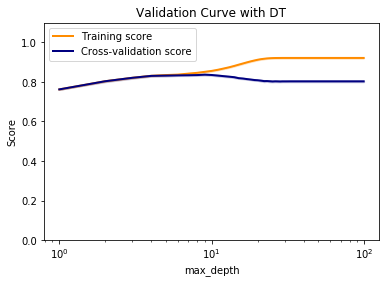

In [13]:
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=5), X, y, param_name="max_depth", param_range=tree_depth,
    cv=5, scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with DT")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(tree_depth, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(tree_depth, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(tree_depth, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(tree_depth, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [14]:
# Task 2 2a
print("Train accuracy:", gs.score(X_train, y_train))
print("Test accuracy:", gs.score(X_test, y_test))


Train accuracy: 0.8512336188593601
Test accuracy: 0.8321803740712272
